# Выбор локации для скважины

Основная задача: нужно решить, где бурить новую скважину.

В наличии пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. А затем - проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## 1. Загрузка и подготовка данных

### Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
    
    /datasets/geo_data_0.csv. 
    /datasets/geo_data_1.csv. 
    /datasets/geo_data_2.csv. 

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

### Импорт библиотек

In [1]:
import pandas as pd #импорт библиотеки pandas
import numpy as np #импорт библиотеки numpy
import seaborn as sns #импорт библиотеки seaborn

from sklearn.model_selection import train_test_split #импорт инструмента для разделения выборок

from sklearn.linear_model import LinearRegression #импорт модели линейной регрессии

from sklearn.metrics import mean_squared_error #импорт метрики MSE
from sklearn.metrics import r2_score #импорт метрики r2

RS=12345 #константа для аргумента random_state

from tqdm import tqdm #импорт библиотеки для отображения процесса выполнения кода

### Импорт исходных данных

In [2]:
try:
    #путь для работы
    df0=pd.read_csv('geo_data_0.csv')
    df1=pd.read_csv('geo_data_1.csv')
    df2=pd.read_csv('geo_data_2.csv')


except:
    #путь для ревьюера
    df0=pd.read_csv('/datasets/geo_data_0.csv')
    df1=pd.read_csv('/datasets/geo_data_1.csv')
    df2=pd.read_csv('/datasets/geo_data_2.csv')

Изучим общую информацию о полученных датафреймах.

Датасет df0:

In [3]:
#вывод информации методом info()
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
#вывод информации методом describe()
df0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [5]:
#просмотр 5 первых строк датафрейма
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Датасет df1:

In [6]:
#вывод информации методом info()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
#вывод информации методом describe()
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
#просмотр 5 первых строк датафрейма
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Датасет df2:

In [9]:
#вывод информации методом info()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
#вывод информации методом describe()
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [11]:
#просмотр 5 первых строк датафрейма
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


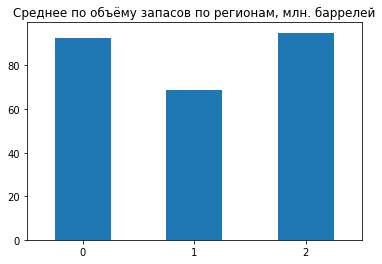

In [12]:
#посмотрим на соотношение средних значений запасов по регионам
df_012_product=pd.concat([pd.Series(df0['product'].mean()),pd.Series(df1['product'].mean()),pd.Series(df2['product'].mean())],ignore_index=True)
df_012_product.plot.bar(title='Среднее по объёму запасов по регионам, млн. баррелей', rot=0);

По предварительному просмотру информации о датафреймах можно утверждать следующее:

    Во всех трёх таблицах нет пропусков;
    В первом и третьем регионах геологоразведки сопоставимые запасы нефти (92,5 и 95 млн. баррелей), а во втором - меньше(68,8 млн. баррелей);
    Минимальные значения запаов во всех трёх регионах равны 0 (видимо есть уже отработанные или просто пустые скважины);
    Максимальные значения запасов распределены аналогично средним значениям

  
Сначала проведём проверку на полные дубликаты:<br></div> 

In [13]:
dfs=[df0,df1,df2]
for i in dfs:
    dup=i.duplicated().sum()
    print(dup)

0
0
0



    
Как видно, полных дубликатов в датафреймах не встречается. Рассмотрим дубликаты по столбцам

In [14]:
#пройдём по всем таблицам и по всем столбцам
for i in [df0,df1,df2]:
    for name,values in i.iteritems():
        print(name,values.duplicated().sum())

id 10
f0 0
f1 0
f2 0
product 0
id 4
f0 0
f1 0
f2 0
product 99988
id 4
f0 0
f1 0
f2 0
product 0



Заметно следующее: есть дубликаты по id для первого региона (при этом значения других параметров не повторяются, лучше удалить дубликаты), а также большое количество дубликатов для значений product для второго региона (в этом может быть какой-то смысл: воможно, результаты исследований были округлены до неких ключевых значений запасов при обработке исходных данных, а возможно так как данные синтетические, данный столбец был размножен из нескольких уникальных значений до 10000 строк).<br></div> 

In [15]:
#сброс дубликатов по id для первого региона
df0=df0.drop_duplicates(subset=['id'],keep='first')
#проверка
df0.shape[0]

99990


    
Дубликаты по Id удалены.<br></div> 


    
Рассмотрим гистограммы для регионов.<br></div> 

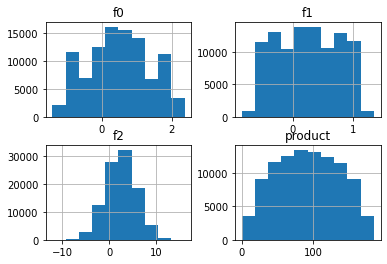

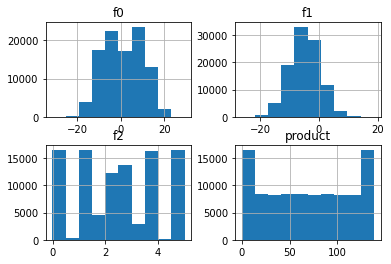

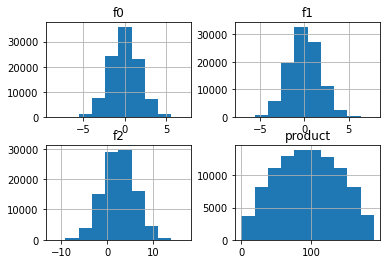

In [16]:
dfs=[df0,df1,df2]
for i in dfs:
    i.hist();


    
**Первый регион:** Распределения величин f2, product похожи на нормальные. f1 - разброс между значениями невелик, а f0 похоже на нормальное, с имеющимися дополнительными выбросами.
    
**Второй регион:** Распределения величин f0, f1 похожи на нормальные,  а вот f2,product иные: такое ощущение, что и там, и там значения лежат по нескольким корзинам, что косвенно может подветрждать вывод о том, что данные были округлены по нескольим параметрам при сборе, или размножены до 10000 из исходных 8-10 наборов (судя по столбцам f2) 
    
**Третий регион:** В данном регионе все величины распределены нормально, возможно, это наиболее реальный набор данных из всех трёх.    


    
Посмотрим на корреляции между признаками. Построим матрицу корреляций и тепловую карту:<br></div> 

In [17]:
dfs=[df0,df1,df2]
for i in dfs:
    print(i.corr())

               f0        f1        f2   product
f0       1.000000 -0.440717 -0.003211  0.143504
f1      -0.440717  1.000000  0.001764 -0.192351
f2      -0.003211  0.001764  1.000000  0.483631
product  0.143504 -0.192351  0.483631  1.000000
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


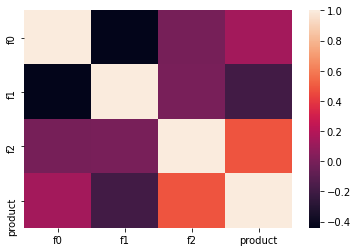

In [18]:
#первый регион
sns.heatmap(df0.corr());

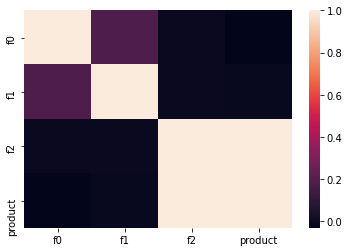

In [19]:
#второй регион
sns.heatmap(df1.corr());

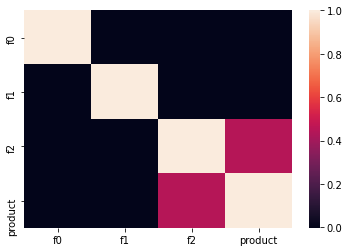

In [20]:
#третий регион
sns.heatmap(df2.corr());


Исходя из полученного, видно, что:
    
**Для первого региона** видна сильная взаимосвязь между product и f2. При этом существуют ещё корреляции f0-f1(отрицательная), f0-product(0.15).
    
**Для второго региона** видна ещё более сильная взаимосвязь между product и f2. При этом существуют ещё корреляции f0-f1(0.18). 
    
**Для третьего региона** также видна сильная взаимосвязь между product и f2. 
    
Отсюда напрашивается следующая мысль: для всех трёх регионов значение f2 для определения запасов имеет наибольший вес. При этом, для первого региона существуют зависимости между параметрами f0,f1,f2, что, возможно, говорит о низком качестве датасета для первых двух регионов: ведь если мы берём 3 геологических параметра для суждения о том, как они влияют на четвёртый параметр (запасы ископаемых), то, возможно, есть смысл брать независимые друг от друга параметры (ведь тогда можно было бы приводить их друг к другу и строить зависимость от одного из параметров). Ну то есть если мы берём условно геологические изыскания, в них есть (это предположение и только, пойду гуглить потом дальше:)): вода, содержание каких-то элементов в почве, тип грунта. И если тип грунта зависит от количества воды, то тогда есть смысл коррелировать не тип грунта - содержание нефти, а просто вода - нефть, тк они зависят друг от друга (так получается для первого датасета). А для второго и третьего региона такой проблемы нет: f0,f1,f2 друг с другом коррелируют очень слабо. Косвенно это может быть подтверждено и тем, что распределение параметров для третьего региона было наиболее нормальным: возможно датасет третьего региона более настоящий, чем остальные)   <br></div> 

## 2. Обучение и проверка модели

### 2.1 Разбивка данных на обучающую и валидационную выборки 

Разбивку будем производить в соотношении 75:25. Также для обучения и предсказания нет смысла оперировать столбцом с id, так что его удаляем.

In [23]:
#первый регион (df0)
#удаление столбца с id
df0=df0.drop(['id'],axis=1)
#разделение выборок на обучающую и валидацинную в соотношении 75:25
target_0=df0['product']
features_0=df0.drop(['product'],axis=1)
features_0_train,features_0_valid,target_0_train,target_0_valid=train_test_split(
features_0,target_0,train_size=0.75,random_state=RS)

In [24]:
#второй регион (df1)
#удаление столбца с id
df1=df1.drop(['id'],axis=1)
#разделение выборок на обучающую и валидацинную в соотношении 75:25
target_1=df1['product']
features_1=df1.drop(['product'],axis=1)
features_1_train,features_1_valid,target_1_train,target_1_valid=train_test_split(
features_1,target_1,train_size=0.75,random_state=RS)

In [25]:
#третий регион (df2)
#удаление столбца с id
df2=df2.drop(['id'],axis=1)
#разделение выборок на обучающую и валидацинную в соотношении 75:25
target_2=df2['product']
features_2=df2.drop(['product'],axis=1)
features_2_train,features_2_valid,target_2_train,target_2_valid=train_test_split(
features_2,target_2,train_size=0.75,random_state=RS)

### 2.2 Обучение модели и предсказание на валидационной выборке

Обучим модели линейной регрессии для трёх регионов и сохраним предсказания на валидационной выборке

In [26]:
#первый регион (df0)
model_0=LinearRegression()
model_0.fit(features_0_train,target_0_train)
predictions_0_valid=model_0.predict(features_0_valid)

In [27]:
#второй регион (df1)
model_1=LinearRegression()
model_1.fit(features_1_train,target_1_train)
predictions_1_valid=model_1.predict(features_1_valid)

In [28]:
#третий регион (df2)
model_2=LinearRegression()
model_2.fit(features_2_train,target_2_train)
predictions_2_valid=model_2.predict(features_2_valid)

### 2.3. Сохранение предсказаний и правильных ответов на валидационной выборке

    Предсказания уже сохранены в переменной predictions_*номер df*_valid.
    Правильные ответы сохранены в переменной target_*номер df*_valid

### 2.4. Отображение на экране среднего запаса предсказанного сырья и RMSE моделей.

In [29]:
#первый регион (df0)
predictions_0_valid_mean=predictions_0_valid.mean()
model_0_RMSE=mean_squared_error(target_0_valid,predictions_0_valid)**0.5

In [30]:
#второй регион (df1)
predictions_1_valid_mean=predictions_1_valid.mean()
model_1_RMSE=mean_squared_error(target_1_valid,predictions_1_valid)**0.5

In [31]:
#третий регион (df2)
predictions_2_valid_mean=predictions_2_valid.mean()
model_2_RMSE=mean_squared_error(target_2_valid,predictions_2_valid)**0.5

In [32]:
results_2=pd.DataFrame({'средний запас предсказанного сырья':
                      [predictions_0_valid_mean,predictions_1_valid_mean,predictions_2_valid_mean],
                     'RMSE модели':
                     [model_0_RMSE,model_1_RMSE,model_2_RMSE]})

results_2

,средний запас предсказанного сырья,RMSE модели
0,92.789156,37.853527
1,68.728547,0.893099
2,94.965046,40.029709


### 2.5 Анализ результатов

Для первого и третьего региона значение ошибки RMSE имеет сопоставимую величину, при этом погрешность значительна: RMSE почти равняется половине от среднего значения запаса. При этом, для второго региона значение RMSE значительно меньше: на 2 порядка модель точнее. Значения средних предсказанных запасов схожи со средним по всему столбцу product, что вполне закономерно.

## 3. Подготовка к расчёту прибыли

### 3.1. Сохранение ключевых значений

Запишем все необходимые значения в различные переменные.

In [33]:
#число точек для разведки
exploration_number=500

#число точек для разработки
mining_number=200

#бюджет на разработку скважин в регионе, тыс. рублей
mining_budget=10000000

#цена за 1000 баррелей, тыс. рублей
barrels_price=450

#порог вероятности убытков,%
risk_value=2.5

### 3.2. Расчёт достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма со средним запасом в каждом регионе.

Объём для безубыточной разработки - это объём сырья, при продаже которого будет заработано столько денег, сколько на неё было затрачено - 10 млрд рублей (константа mining_budget). Сохраним значение в константу как break_even_point (точка безубыточности)


In [34]:
#расчёт точки безубыточной разработки кол-во баррелей(тысячи шт.): 
#затраты на регион(тыс. рублей)/(кол-во скважин на регион(mining_number, шт)*цена за 1000 баррелей(тыс. рублей))
break_even_point=mining_budget/(mining_number*barrels_price)
break_even_point

111.11111111111111

Сравним со средним по регионам:

In [35]:
df_means=pd.DataFrame({'среднее по регионам':[df0['product'].mean(),df1['product'].mean(),df2['product'].mean()]})
df_means['отношение к точке безубыточности']=df_means['среднее по регионам']/break_even_point
df_means

,среднее по регионам,отношение к точке безубыточности
0,92.499684,0.832497
1,68.825000,0.619425
2,95.000000,0.855000


### 3.3. Выводы по этапу подготовки расчёта прибыли

Отсюда видно, что во всех трёх регионах среднее значение запасов по всем скважинам меньше минимального значения запасов, чтобы бурение скважины было безубыточным. При этом во втором регионе среднее значение меньше всех: на 39% относительно безубыточных запасов, а для первого и третьего региона примерно одинаково: на 17 и 15 процентов соответственно. 

Получается, для безубыточного бурения необходимо выбирать скважины, запасы в которых будут значительно больше, чем в среднем по региону, и в особенностиэто важно для второго региона

## 4. Расчёт прибыли

Для расчёта прибыли по выбранным скважинам напишем функцию, которая будет выбирать скважины с максимальными значениями предсказаний, просуммирует целевое значение объёма сырья, соответствующее этим предсказаниям, рассчитает прибыль для полученного объёма сырья.

In [36]:
def revenue(predictions,target):
    #делаем из predictions объект Series, с индексами из target
    predictions=pd.Series(predictions,index=target.index)
    #сортируем скважины по убыванию значения предсказанных запасов
    predictions_sorted=predictions.sort_values(ascending=False)
    #выбираем реальные запасы для этих скважин, 200 (mining_number) штук
    selected=target[predictions_sorted.index][:mining_number]
    #рассчитаем прибыль для суммарного объёма сырья для этих скважин
    #прибыль(тыс.рублей) =  суммарный объём сырья(selected.sum()), тыс. баррелей *\ 
    #цена за тысячу баррелей(barrels_price), тыс. рублей -\
    #затраты на разработку этих скважин(mining_budget), тыс. рублей
    return selected.sum()*barrels_price-mining_budget

Расчитаем прибыль для всех регионов:

In [37]:
#регион 1 (df0)
revenue_0=revenue(predictions_0_valid,target_0_valid)

#регион 2 (df1)
revenue_1=revenue(predictions_1_valid,target_1_valid)

#регоин 3 (df2)
revenue_2=revenue(predictions_2_valid,target_2_valid)

revenues=pd.DataFrame({'прибыль по регионам, тыс. рублей':[revenue_0,revenue_1,revenue_2]})
revenues

,"прибыль по регионам, тыс. рублей"
0,3.365187e+06
1,2.415087e+06
2,2.710350e+06


По данным расчётам получаем, что вот не смотря на то, что 1 и 3 регион по средним запасам одинаковы, первый оказывается сильно прибыльнее, чем третий. При этом предсказкуемо прибыльность 2 региона меньше, но не так значительно как соотношение средних запасов (очень грубо 60 к 90). 

## 5. Подсчёт рисков и прибылей для каждго региона

### 5.1. Применение техники Bootstrap c 1000 выборок, чтобы найти распределение прибыли

In [38]:
#регион 1 (df0)
#создание списка со значениями revenue для каждой выборки
values_0=[]

state=np.random.RandomState(12345)
for i in range(1000):
    target_0_subsample=target_0_valid.sample(n=exploration_number,random_state=state,replace=True) #создание подвыборки target на 500 скважин
    predictions_0_valid=pd.Series(predictions_0_valid,index=target_0_valid.index) #создание объекта Series для дальнейшей обработки 
    predictions_0_subsample=predictions_0_valid[target_0_subsample.index] #создание подвыборки predictions для соотвествующих target
    values_0.append(revenue(predictions_0_subsample,target_0_subsample)) #вычисление функции revenue
    
#регион 2 (df1)
#создание списка со значениями revenue для каждой выборки
values_1=[]

state=np.random.RandomState(12345)
for i in range(1000):
    target_1_subsample=target_1_valid.sample(n=exploration_number,random_state=state,replace=True) #создание подвыборки target на 500 скважин
    predictions_1_valid=pd.Series(predictions_1_valid,index=target_1_valid.index) #создание объекта Series для дальнейшей обработки 
    predictions_1_subsample=predictions_1_valid[target_1_subsample.index] #создание подвыборки predictions для соотвествующих target
    values_1.append(revenue(predictions_1_subsample,target_1_subsample)) #вычисление функции revenue
    
#регион 3 (df2)
#создание списка со значениями revenue для каждой выборки
values_2=[]

state=np.random.RandomState(12345)
for i in range(1000):
    target_2_subsample=target_2_valid.sample(n=exploration_number,random_state=state,replace=True) #создание подвыборки target на 500 скважин
    predictions_2_valid=pd.Series(predictions_2_valid,index=target_2_valid.index) #создание объекта Series для дальнейшей обработки 
    predictions_2_subsample=predictions_2_valid[target_2_subsample.index] #создание подвыборки predictions для соотвествующих target
    values_2.append(revenue(predictions_2_subsample,target_2_subsample)) #вычисление функции revenue

### 5.2 Нахождение средней прибыли, 95%-ого доверительного интервала и риска убытков

In [39]:
#регион 1 (df0)
values_0=pd.Series(values_0) #создание объекта Series для полученных values
values_0_mean=values_0.mean() #подсчёт среднего по выборке
lower_0=values_0.quantile(0.025) #отбор нижней границы 95% доверительного интервала
upper_0=values_0.quantile(0.975) #отбор верхней границы 95% доверительного интервала

loss_0=100*values_0[values_0<0].count()/len(values_0) #доля убытков,% 

#регион 2 (df1)
values_1=pd.Series(values_1) #создание объекта Series для полученных values
values_1_mean=values_1.mean() #подсчёт среднего по выборке
lower_1=values_1.quantile(0.025) #отбор нижней границы 95% доверительного интервала
upper_1=values_1.quantile(0.975) #отбор верхней границы 95% доверительного интервала
loss_1=100*values_1[values_1<0].count()/len(values_1) #доля убытков 

#регион 3 (df2)
values_2=pd.Series(values_2) #создание объекта Series для полученных values
values_2_mean=values_2.mean() #подсчёт среднего по выборке
lower_2=values_2.quantile(0.025) #отбор нижней границы 95% доверительного интервала
upper_2=values_2.quantile(0.975) #отбор верхней границы 95% доверительного интервала
loss_2=100*values_2[values_2<0].count()/len(values_2) #доля убытков 

results_5=pd.DataFrame({'среднее':[values_0_mean,values_1_mean,values_2_mean],'0.025-квантиль':[lower_0,lower_1,lower_2],
                        '0.975':[upper_0,upper_1,upper_2],'доля убытков,%':[loss_0,loss_1,loss_2]})
results_5

,среднее,0.025-квантиль,0.975,"доля убытков,%"
0,409428.038621,-131536.028702,944395.582755,7.1
1,515222.773443,68873.225371,931547.591257,1.0
2,435008.362783,-128880.547330,969706.954180,6.4


### 5.3 Выводы.

Исходя из основного условия задачи, а именно: после оценки рисков оставить лишь те регионы, в которых вероятность убытков меньше 2,5%, получаем, что подходит для разработки только второй регион (df1) с вероятностью убытков 1%. Для первого и третьего регионов вероятность убытков составляет 6,0 и 6,4 процента соответственно.

Также интересно отметить, что для второго региона 0.025-квантиль положителен (то есть если считать долю убытков только по доверительному интервалу, то она будет стремиться к нулю).